# Spatial indexing

### 02_02 Getting hands-on with H3

Now let's import the necessary libraries and also the previously studied NUTS dataset. Also, make sure we restrict this dataset to Germany to have an easy-to-manage volume of data at hand.

Besides the usual imports, we will now import the h3 library, specifically developed to do Uber's h3 spatial indexing.

In [2]:
import geopandas as gpd  
from shapely.geometry import Polygon
import matplotlib.pyplot as plt 
import numpy as np
from shapely.geometry import Point

import h3

import warnings
warnings.filterwarnings('ignore')

gdf_nuts1 = gpd.read_file("NUTS 1 - 2016")  
gdf_nuts1 = gdf_nuts1[gdf_nuts1.CNTR_CODE=='DE']

As a test, let's define a random point in Germany by its longitude and latitude coordinates.

Then we will query its spatial index in the H3 framework. Here we note, that H3 comes in different spatial resolutions. With resolution 0 being the largest (1281 km edge length) and covering a substantial portion of the Earth, and higher resolutions providing smaller and more precise hexagons, and going down to resolution 15 (around 0.55m). For instance, detailed urban analytics projects usually work using resolutions of 8-11. 

However, now we will work with country-level Germany, so let's choose resolution 5:



In [3]:
latitude, longitude = 48.210033, 16.363449

resolution = 5

Then we simply need to call the geo_to_h3 function of h3, which will immediately output the index:

In [4]:
h3_index = h3.geo_to_h3(latitude, longitude, resolution)
print("H3 Index:", h3_index, "\n")


H3 Index: 851e15b7fffffff 



While I have been talking about hexagons, this is nothing but a string. However, this is a bit more - this is a 64-bit identifier encoding
- Mode & resolution: The first hex digit (8) signals it’s a cell‐index (mode 1), and the second digit (5) gives you the resolution (here, resolution 5).
- Grid address: The next bits (1e15b7) locate which base cell and which child‐hex within it you’re talking about.
- Trailing f digits: Those final fs fill out the unused resolution slots—essentially “no finer child” beyond resolution 5.

To interpret it, let's check the following h3 functions

In [7]:
res = h3.h3_get_resolution(h3_index)
print(f"Resolution: {res}")

Resolution: 5


In [8]:
lat, lng = h3.h3_to_geo(h3_index)
print(f"Centroid:  (lat={lat:.6f}, lng={lng:.6f})")

Centroid:  (lat=48.195939, lng=16.413621)


In [9]:
boundary = h3.h3_to_geo_boundary(h3_index)
print("Boundary coordinates:")
for pt in boundary:
    print(f"  - (lat={pt[0]:.6f}, lng={pt[1]:.6f})")

Boundary coordinates:
  - (lat=48.234683, lng=16.294542)
  - (lat=48.148997, lng=16.297059)
  - (lat=48.110195, lng=16.416002)
  - (lat=48.157040, lng=16.532613)
  - (lat=48.242748, lng=16.530362)
  - (lat=48.281589, lng=16.411234)


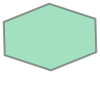

In [10]:
hexagon = Polygon([(pt[1], pt[0]) for pt in boundary])
hexagon

This example illustrates the basic usage of H3 in obtaining the enclosing hexagon id, its boundary coordinates, and the hexagon polygon itself.

### 02_03 Visualizing H3 Grids

As we keep experimenting with different spatial scales, now let's zoom in to one specific NUTS' area - the one around Berlin.



,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
22,1,DE3,DE,BERLIN,0,0,0,DE3,"POLYGON ((13.69974 52.37788, 13.69901 52.37439..."


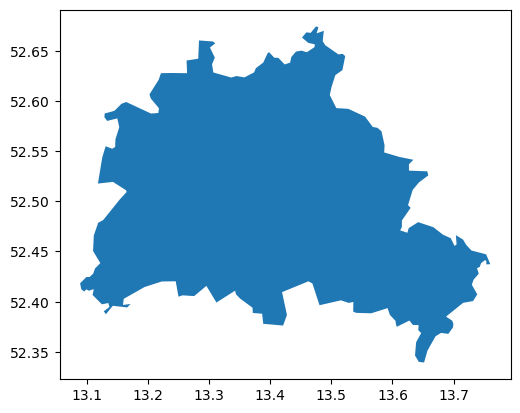

In [38]:
# focus in the Berlina re as an example
gdf_example = gdf_nuts1[gdf_nuts1.NUTS_NAME == 'BERLIN']
gdf_example.plot()
gdf_example

Then, let's also turn this geojson into coordinates and turn into a geojson dictionary format which is expected by the h3 library.

Namely, we will use the polyfill function of the h3 library, which simply takes such a polygon coordinate dictionary and fills it up with hexagons. It will return a list of hexagon indices, which we will then need to turn into polygon geometries to be able to place on a map.


In [39]:
# extract exterior coords of the first (and only) polygon
coords = list(gdf_example.geometry.to_list()[0].exterior.coords)

# build a GeoJSON-like dict that h3.polyfill expects
admin_geojson = {
    "type": "Polygon",
    "coordinates": [coords]
}

hexagons = h3.polyfill(admin_geojson,  resolution, geo_json_conformant=True)
hexagons

{'881f189493fffff',
 '881f1d4139fffff',
 '881f1d4131fffff',
 '881f1894d5fffff',
 '881f1d4e27fffff',
 '881f1884dbfffff',
 '881f1886bdfffff',
 '881f1d4f05fffff',
 '881f18b337fffff',
 '881f1d41a9fffff',
 '881f1d59a9fffff',
 '881f18b20dfffff',
 '881f18b219fffff',
 '881f18b5ddfffff',
 '881f18b453fffff',
 '881f18b559fffff',
 '881f1d4a55fffff',
 '881f1d4f37fffff',
 '881f18949bfffff',
 '881f1d4c15fffff',
 '881f1d4f27fffff',
 '881f1d4d6dfffff',
 '881f1d4a2dfffff',
 '881f1d41d5fffff',
 '881f18b2edfffff',
 '881f1d4193fffff',
 '881f18b2bdfffff',
 '881f18868dfffff',
 '881f1d4b47fffff',
 '881f18b2cdfffff',
 '881f1886c3fffff',
 '881f1d4b39fffff',
 '881f18b55bfffff',
 '881f1d4a67fffff',
 '881f18b06bfffff',
 '881f1d48edfffff',
 '881f18b2e5fffff',
 '881f18b43dfffff',
 '881f189499fffff',
 '881f1d4e45fffff',
 '881f1d4ddbfffff',
 '881f1d48cdfffff',
 '881f18b661fffff',
 '881f1d4f5bfffff',
 '881f18b53bfffff',
 '881f1d4189fffff',
 '881f1d4919fffff',
 '881f1d4811fffff',
 '881f18b02bfffff',
 '881f18b267fffff',


,hex_id,geometry
0,881f189493fffff,"POLYGON ((13.16901 52.51171, 13.16681 52.50746..."
1,881f1d4139fffff,"POLYGON ((13.34096 52.61845, 13.33874 52.61421..."
2,881f1d4131fffff,"POLYGON ((13.34405 52.61126, 13.34184 52.60702..."
3,881f1894d5fffff,"POLYGON ((13.12744 52.52387, 13.12525 52.51962..."
4,881f1d4e27fffff,"POLYGON ((13.49147 52.57837, 13.48924 52.57413..."
...,...,...
1347,881f1d4b4bfffff,"POLYGON ((13.17947 52.57149, 13.17727 52.56725..."
1348,881f1d416dfffff,"POLYGON ((13.27674 52.62679, 13.27453 52.62255..."
1349,881f188655fffff,"POLYGON ((13.14924 52.47348, 13.14704 52.46923..."
1350,881f18b4edfffff,"POLYGON ((13.70062 52.42802, 13.69838 52.42378..."


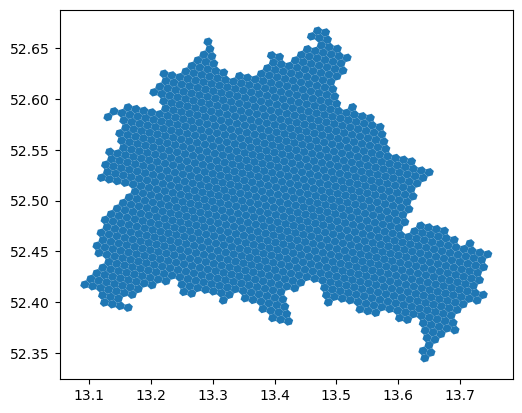

In [40]:
# turning this into a geodataframe
hexagon_geometries = {hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, \
                                geo_json=True)) for hex_id in hexagons}
gdf_hexagon_geometries = gpd.GeoDataFrame(hexagon_geometries.items(), 
                                columns=['hex_id', 'geometry'])
gdf_hexagon_geometries.crs = gdf_example.crs
gdf_hexagon_geometries.plot()
gdf_hexagon_geometries

Here we have something remotetly resembling to thje Berlin polygon. The reason is that our resolution parameter is still cached as 5.

Since we will be generating more of these grid polygon geodataframes later, now let's package the previous steps together into a function:

In [41]:
# Function to split an administrative boundary into a hexagon grid
def split_poly_to_hexagons(admin_gdf, resolution, crs):
    
    coords = list(admin_gdf.geometry.to_list()[0].exterior.coords)
    admin_geojson = {"type": "Polygon",  "coordinates": [coords]}
    hexagons = h3.polyfill(admin_geojson, 
                           resolution, 
                           geo_json_conformant=True)
    
    hexagon_geometries = {hex_id: Polygon(h3.h3_to_geo_boundary(hex_id, \
                                geo_json=True)) for hex_id in hexagons}
    gdf_hexagon_geometries = gpd.GeoDataFrame(hexagon_geometries.items(), 
                                    columns=['hex_id', 'geometry'])
    gdf_hexagon_geometries.crs = crs
    
    return gdf_hexagon_geometries

And then call this function on the Berlin data frame, now at a resolution of 7.

Then, we also visuale the grid using matplotlib and the usual tricks.

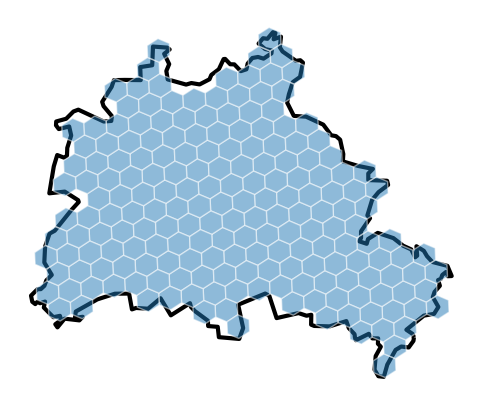

In [42]:
# Define the H3 resolution
resolution = 7

# Create a hexagonal grid within the boundary of Germany
gdf_hexagons = split_poly_to_hexagons(gdf_example, resolution, gdf_example.crs)

# Visualize the hexagonal grid
f, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the boundary of Germany
gdf_example.plot(ax=ax, color='none', edgecolor='k', linewidth=3)

# Plot the hexagonal grid
gdf_hexagons.plot(ax=ax, edgecolor='w', alpha=0.5)
ax.axis('off')
plt.show()

In this example, we reviewed how to create an H3 hexagon grid from a given input polygon and how to visualize it along the initial input polygon using Matplotlib.

While the results look similar to the 25x25km grid we created in the previous section, here, there is a very advanced index system behind splitting the polygon into a set of grid cells. This H3 system then comes with many built-in functions as well as has solid theoretical foundations and universality globally.

Now, let's move on to see how we can use it for spatial computations!

### 02_03 Map elevation data points into hexagons

To demonstrate how we can use h3, we will aggregate point data with continuous feature values.

Luckily, in the previous section, we created a large point vector file containing elevation data across Germany. Let's read it now, and also filter it down to the Berlin area using an overlay command. 

To have enough data at hend, here I used a larger, 1% subsampling ratio.

In [43]:
gdf_elevation = gpd.read_file('Germany_elevation_grid.geojson')
gdf_elevation = gpd.overlay(gdf_elevation, gdf_example[['geometry']])
len(gdf_elevation)

1400

Now let's also create a grid, focusing on Berlin, and visualize the two data sets of the same area next to each other

,hex_id,geometry
0,871f1d41cffffff,"POLYGON ((13.38304 52.63333, 13.38392 52.6219,..."
1,871f18b6affffff,"POLYGON ((13.69815 52.46243, 13.69897 52.45096..."
2,871f1d4abffffff,"POLYGON ((13.3529 52.56256, 13.35378 52.55112,..."


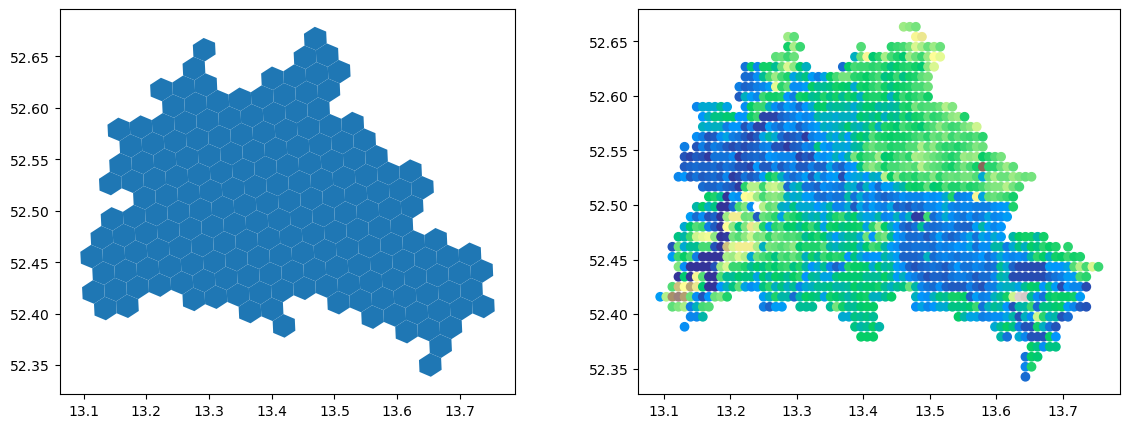

In [48]:
resolution = 7
gdf_hexagons = split_poly_to_hexagons(gdf_example, resolution, gdf_example.crs)

f, ax = plt.subplots(1,2,figsize=(14,5))

gdf_hexagons.plot(ax=ax[0])
gdf_elevation.plot(ax=ax[1], cmap  = 'terrain', column = 'elev_m')
gdf_hexagons.head(3)

Now we have two data sets of the same area. Now, what we will do is we will use the hexagon grid to aggregate the raster data spatially. This way we can easily move from thousands or, in some cases, millions of data points, into a well-structured, easy-to-visualize, aggregated spatial view of the same dataset. 

Such indexing and aggregation are also great to illustrate data density and simplify future computations.

Let'S do the merging by relying on  simple spatial join to link every pixel-level point from the elevation data set to its enclosing hexagon:

In [49]:
pts_with_hex = gpd.sjoin(
    gdf_elevation,                       # left: points
    gdf_hexagons[["hex_id", "geometry"]],# right: polygons (keep only needed cols)
    how="inner",
    predicate="within",             # each point must be inside its hex
)

pts_with_hex.head(3)

,elev_m,geometry,index_right,hex_id
0,60.0,POINT (13.46083 52.66333),102,871f1d40cffffff
1,59.0,POINT (13.47 52.66333),102,871f1d40cffffff
2,57.0,POINT (13.47917 52.66333),102,871f1d40cffffff


Then compute the hexagon-level statistics, such as the mean elevation level, by using a simple pandas groupby command, and then joining the values back to the hexagon grid GeoDataFrame.

This is the point where we can select any (even multiple) types of spatial aggregations we would like to apply on our data. This may be especially useful if we have a large, or noisy spatial data set and we aim to extract patterns and uncover trends by aggregating to larger units.

Also, when it comes to aggregation, we have to point out that at any step of this pipeline we can change the h3 resolution. Moreover, I recommend you to test what are the smallest and largest resolution levels where the analysis provides meaningful outcomes.

In [50]:
mean_elev = (
    pts_with_hex.groupby("hex_id")["elev_m"]
    .mean()
    .rename("mean_elev_m")
)

gdf_hexagons = gdf_hexagons.join(mean_elev, on="hex_id")
gdf_hexagons.head(3)

,hex_id,geometry,mean_elev_m
0,871f1d41cffffff,"POLYGON ((13.38304 52.63333, 13.38392 52.6219,...",54.285714
1,871f18b6affffff,"POLYGON ((13.69815 52.46243, 13.69897 52.45096...",50.000000
2,871f1d4abffffff,"POLYGON ((13.3529 52.56256, 13.35378 52.55112,...",42.375000


Finally, let's visualze this - and see how the spatial binning via h3 indicies looks like on a map, showing the elevation levels within Berlin.

Text(526.3777777777779, 0.5, '--')

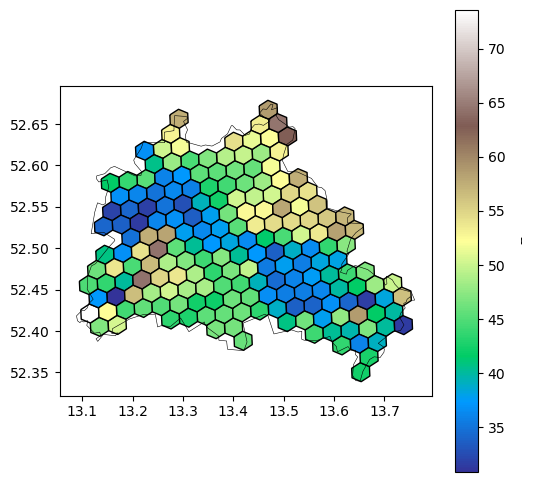

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))

# outline first
gdf_example.boundary.plot(ax=ax, linewidth=0.4, color="black")

# choropleth + colour-bar
gdf_hexagons.plot(
    ax=ax,
    column="mean_elev_m",
    cmap="terrain",
    legend=True,            # GeoPandas creates the colour-bar for us
    edgecolor="black",
)

cbar_ax = fig.axes[-1]      # the colour-bar is the last axis in the figure
cbar_ax.set_ylabel("--", rotation=270, labelpad=15, fontsize=9)


As this visual also shows, by using h3, we can split any unevenly shaped polygon into a regular hexagon grid. Then, combining it with various data, for instance, points, even extracted from raster grids, we can aggregate, visualize, and prepare for further analysis nearly any type and size of vector data.